In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from keras.layers import Dense, LSTM, Dropout
import xgboost
from xgboost import XGBRegressor
print("xgboost", xgboost.__version__)
import warnings
warnings.filterwarnings("ignore")

xgboost 1.6.2


# Data visualization

## Loading the data

In [2]:
train_visuals = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
train_suppl = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
revealed_test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv')

In [3]:
print("Train data columns: ", train_visuals.columns)
print("Census data columns: ", train_suppl.columns)
print("Revealed data columns: ", revealed_test.columns)

Train data columns:  Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active'],
      dtype='object')
Census data columns:  Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')
Revealed data columns:  Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active'],
      dtype='object')


### Converting the dates to days

Combining the `revealed data` and `train data` and then converting `cfips` and `first_day_of_month` to the ascending order integers.

In [4]:
#combining two datasets
train_data = pd.concat([train_visuals, revealed_test])


#assigning the minimum and maximum data for the conversion
min_date = pd.to_datetime(min(train_data['first_day_of_month']))
max_date = pd.to_datetime(max(train_data['first_day_of_month']))
margin =  ( max_date.to_period('M')  ) \
                                   - ( min_date.to_period('M')  ) 


#sorting out the data according to counties and first_day_of_month
train_data = train_data.sort_values(['cfips', 'first_day_of_month'],\
              ascending = [True, True])
train_data = train_data.reset_index()

#creating a dictionary of unique IDs in ascending order
dict_val = {}
for leng, val in enumerate(train_data.cfips.unique()):
    dict_val[val] = leng

    
dates = np.array(train_data['first_day_of_month'])
train_data['numMons'] = " "
months0=np.arange(1,margin.n+2,1)
months=[]
for i in range(len(dict_val)):
    months=np.concatenate((months,months0))
train_data['numMons'] = months
train_data["countyID"] = " "


for leng, val in enumerate(tqdm(train_data['cfips'])):
    train_data.loc[leng,"countyID"] = dict_val[train_data.loc[leng,'cfips']]

100%|██████████| 128535/128535 [05:28<00:00, 391.83it/s]


### Plotting the target variable `microbusiness density`

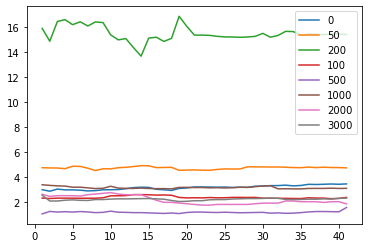

In [5]:
countyId = [0,50, 200,100, 500, 1000, 2000, 3000]
for i in countyId:
    tempdata = train_data[train_data['countyID'] == i]
    plt.plot(tempdata['numMons'], tempdata['microbusiness_density'], label=str(i))
    plt.legend()

There are extreme values like here for `countyID` 2000 and due to this reason, I have fitted the model for each county

### Now, plotting the sum of `microbusiness density` for all counties per each month to see if there is any anomaly for the particular month.

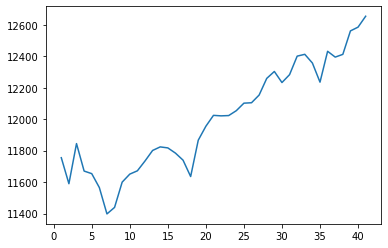

In [6]:
groups = train_data.groupby('numMons')['microbusiness_density'].sum().reset_index()
plt.plot(groups['numMons'], groups['microbusiness_density'])

Overall, the `microbusiness density` is increasing with time. But at the time step 18, there is a large decreasing behaviour. For each county, this shouldn't be a problem.

# Data featuring

#### Firstly, splitting the data into train, test for verification

In [7]:
counties=100
train_data_short =train_data[:41*counties]
print(train_data_short.head())

   index           row_id  cfips          county    state first_day_of_month  \
0      0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1      1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2      2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3      3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4      4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

   microbusiness_density  active  numMons countyID  
0               3.007682    1249      1.0        0  
1               2.884870    1198      2.0        0  
2               3.055843    1269      3.0        0  
3               2.993233    1243      4.0        0  
4               2.993233    1243      5.0        0  


Separating each county data to different elements so we can train it separately.

In [8]:
eachCountyData=[]
loopInd = np.arange(0,41*(counties+1),41)
for ind in range(len(loopInd)-1):
    eachCountyData.append(train_data_short.iloc[loopInd[ind]:loopInd[ind+1],:])

In [9]:
def difference(dataset, interval=[1,2,3,4,5]):
    diff = list()
    for j in interval:
        temp=[]
        for i in range(j, len(dataset)):
            value = dataset[i] - dataset[i - j]
            temp.append(value)
        diff.append(pd.Series(temp))
    diff = pd.concat(diff, axis=1)
    return diff.values

def timeseries_to_supervised(dataset, lag=1):
    df = pd.DataFrame(dataset)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df.values

def splitTestTrain(dataset, breakpoint=35):
    trainSetTar = dataset[0:breakpoint]
    testSetTar = dataset[breakpoint:41]

    return trainSetTar, testSetTar

def scale(train, test):
    # fit scaler
    scaler = RobustScaler()
    #scaler=MinMaxScaler()
    
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def fit_xgboost(train, n_estimators=1000):
    X, y = train[:, 0:-1], train[:, -1]
    #model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators)
    model = XGBRegressor(
         objective='reg:pseudohubererror',
         tree_method="hist",
         n_estimators=795,
         learning_rate=0.075,
         max_leaves = 17,
         subsample=0.50,
         colsample_bytree=0.50,
         max_bin=4096,
         n_jobs=2,
         eval_metric='mape')
         #early_stopping_rounds=70
    model.fit(X,y)
    return model
def forecast_xgboost(model, test):
    X = test[:, 0:-1]
    yhat = model.predict(X)
    return yhat

def invert_scale(scaler, test_scaled, predictions_scaled):
    temparr1 = np.array(test_scaled[:,0:-1])
    temparr2 = np.array(predictions_scaled).reshape(len(predictions_scaled), 1)
    temp_scaled = np.hstack( (temparr1, temparr2) )
    unscaled = scaler.inverse_transform(temp_scaled)[:,-1]
    return unscaled

def inverse_difference(history, yhat, test_scaled, interval=1):
    final_pred=[]
    for i in range(len(test_scaled)):
        final_pred.append(yhat[i] + history[-(len(test_scaled) + interval - i)])
    return np.array(final_pred)





def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
   
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
         model.fit(X, y, epochs=10, batch_size=batch_size, verbose=0, shuffle=False)
    #model.reset_states()
    
    return model

 




In [10]:
trues=[]
preds=[]
for county in tqdm(range(len(eachCountyData))):
    traindataTar = eachCountyData[county]['microbusiness_density'].values
    diff_values = difference(traindataTar,interval=[1])
    supervised = timeseries_to_supervised(diff_values, 1)
    train, test = splitTestTrain(supervised, breakpoint=35)
    scaler, train_scaled, test_scaled = scale(train, test)
    model = fit_xgboost(train_scaled)
    predictions_scaled = forecast_xgboost(model,test_scaled)
    unscaled = invert_scale(scaler, test_scaled, predictions_scaled)
    final_pred = inverse_difference(traindataTar, unscaled, test_scaled, interval=1)

    trues.append(traindataTar[35:40])
    preds.append(final_pred)

100%|██████████| 100/100 [04:12<00:00,  2.53s/it]


In [11]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    #smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    smap=num/dem
    return 100 * np.mean(smap)

1.3138557746200366


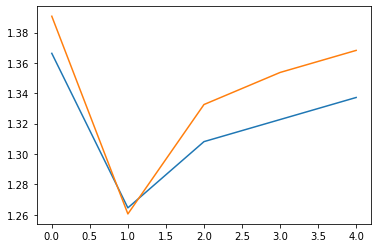

In [12]:
print(smape(np.array(trues), np.array(preds)))
plt.plot(traindataTar[35:40])
plt.plot(final_pred)
plt.show()